# Data Exploration 
Now that we have the streamflow data imported as a CSV file, we move on to the next step in the analytical workflow, namely exploring the data. After we read the data in CSV file back into our session, we will repeat the exploratory analyses we did in Excel:

* Create some scatter plots of the entire dataset as well as for the pre- and post-Falls lake years.


* Convert our CFS data into CMS and MGS units and re-plot.


* Summarize the data by *confidence codes*:
 * Group the data by data-value qualification (i.e., "confidence") codes
 * Determine how many different codes exist in our data and what those codes are
 * Compute the number of records in each code
 * Create a quick bar pot showing the record count in each category


* Compute summary statistics of the entire set of discharge data.
 * Compute min, max, mean, median, as well as specific quantiles.
 * Plot these values
 * Repeat for select years of data (pre- and post- Falls Lake construction)

## Import libraries
First, we need to load a few Python packages build for data analyisis projects.

In [1]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Instruct Jupyter to allow plots in the document itself
%matplotlib inline

## Read the data into a *Pandas* dataframe.
Read in the CSV created in the previous notebook into a new Pandas dataframe. 

In [3]:
#Load the saved csv file, reading the site_no column as a string, not a number.
df = pd.read_csv('GageData.csv', dtype={'site_no':'str'}) 

In [4]:
#Confirm it looks good by viewing the first 5 records
df.head()

,agency_cd,site_no,datetime,MeanFlow_cfs,Confidence
0,USGS,02089000,1930-10-01,210.0,A
1,USGS,02089000,1930-10-02,188.0,A
2,USGS,02089000,1930-10-03,200.0,A
3,USGS,02089000,1930-10-04,200.0,A
4,USGS,02089000,1930-10-05,200.0,A


### Data types
Dataframes are structured so that each column contains values of a constant and defined **data type**. Typical data types in a Pandas dataframe include integers (`int64`), floating point numbers (`float64`), strings (`object`), and date/time objects (`datetime64`).

If we import data into a dataframe, it infers data types from the the values in the input file unless we override the defaults, as we did above with the `site_no` varible. We can view the datatypes in a dataframe via the dataframe's `dtypes` property:

In [5]:
#Show the data types of each column
df.dtypes

agency_cd        object
site_no          object
datetime         object
MeanFlow_cfs    float64
Confidence       object
dtype: object

Note that the `datetime` variable has an incorrectly assigned data type. It is listed as a string (`object`), so we need to re-define it to be a `datetime64` object, specifying the date format our data use.

In [6]:
#Convert datetime to an actual datetime object
df['datetime'] = pd.to_datetime(df['datetime'],format=('%Y-%m-%d'))
df.dtypes

agency_cd               object
site_no                 object
datetime        datetime64[ns]
MeanFlow_cfs           float64
Confidence              object
dtype: object

### Indexes and data slices
Dataframe indexes provide difference ways to select, sort, and organizes rows. By setting our datetime field as an index, we can then select rows by date ranges or "slices". 

In [7]:
#Setting the date time as the index allows time slicing
df.index = df.datetime

In [8]:
#Create two new dataframe views: One with records before Falls Lake an one after
dfPre = df['1930-01-01':'1979-12-31']
dfPost = df['1984-01-01':'2017-12-31']

## Create time series plots of daily discharge data
With our data properly imported and formatted, we can now create some exploratory plots of our data, which may reveal any gaps or outliers of concern. 

Pandas has some plotting capability that will examine. However, we'll also explore the *matplotlib* package, a powerful plotting package that has both Python and R versions, as well as *seaborn* which adds nice aesthetics to our plots. 

#### Create a simple plot using `Pandas` functionality. 

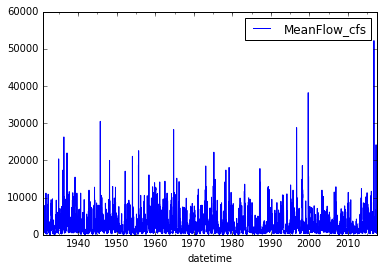

In [9]:
#Plot using Pandas
# https://pandas.pydata.org/pandas-docs/stable/visualization.html
df.plot();

#### Create a time series plot of mean discharge using `matplotlib`
https://matplotlib.org/devdocs/api/pyplot_summary.html

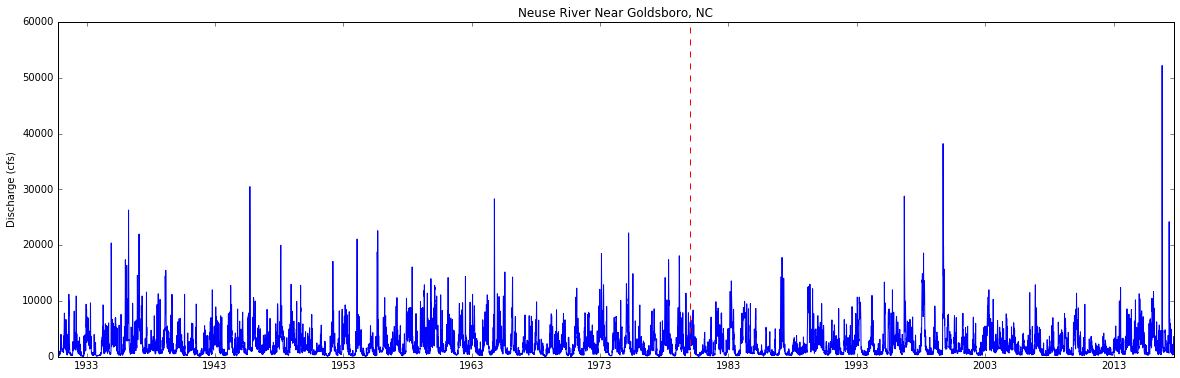

In [10]:
#Create a plot canvas of a specified size
plt.figure(figsize=(20,6));

#Plot the 
plt.plot(df['datetime'],df['MeanFlow_cfs']);

#Add a line indicating when Falls Lake construction began
plt.axvline(x='1980-01-01',color='red',ls='--');

#Add some aesthetics
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

#### Invoke `Seaborn` to make prettier plots 
https://seaborn.pydata.org/tutorial/aesthetics.html


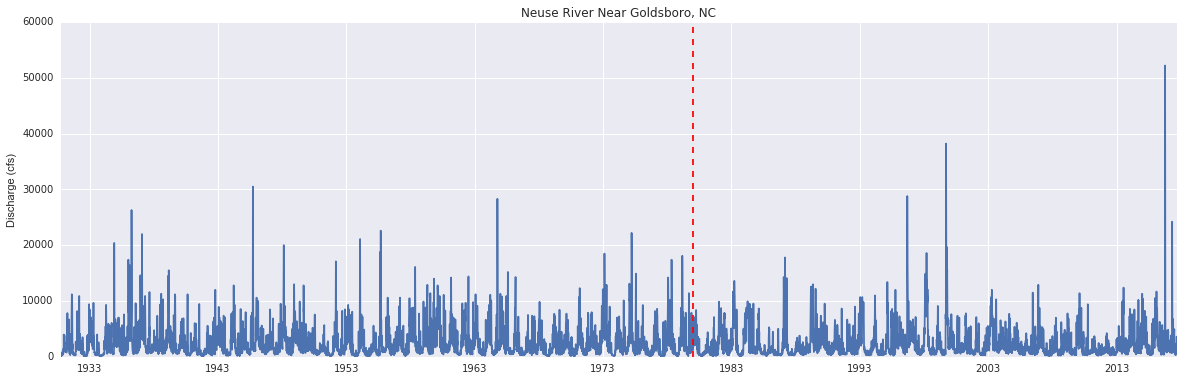

In [11]:
#Activate seaborn default aesthetics
sns.set()
#Repeat above
plt.figure(figsize=(20,6));
plt.plot(df['datetime'], df['MeanFlow_cfs']);
plt.axvline(x='1980-01-01',color='red',ls='--');
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

### Create a plot of all data, superimposed with the pre- and post-Falls Lake data views


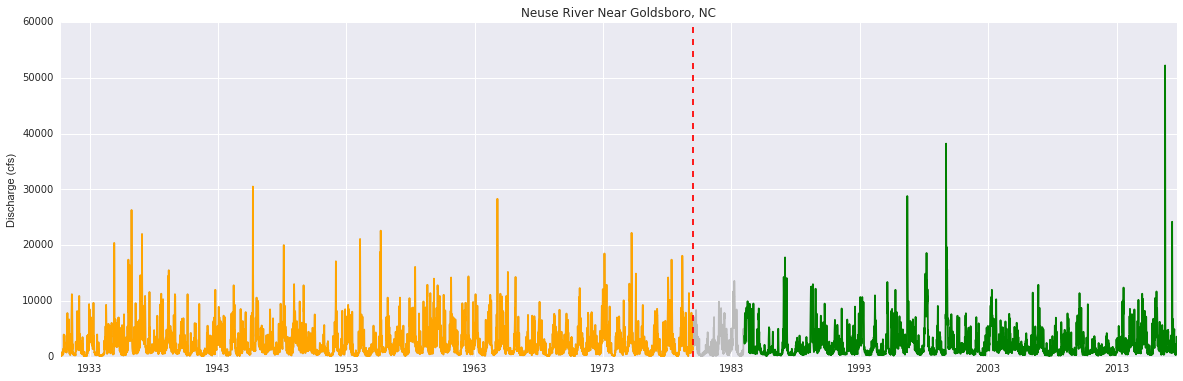

In [12]:
#Create the canvas
plt.figure(figsize=(20,6));

#Add plot lines for the entire dataframe, then the two dataframe subsets
plt.plot(df['datetime'], df['MeanFlow_cfs'],color='#BBBBBB'); #BBBBBBB is light grey
plt.plot(dfPre['datetime'], dfPre['MeanFlow_cfs'],color='orange');
plt.plot(dfPost['datetime'], dfPost['MeanFlow_cfs'],color='green');

#Add the aesthetics
plt.axvline(x='1979-12-31',color='red',ls='--');
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

## Creating derived columns
Here we compute discharge in cubic meters per second (cms) and replot.

In [13]:
#Convert from cfs to cms (1 CFS = 0.028316847 CMS)
df['MeanFlow_mps'] = df['MeanFlow_cfs'] * 0.028316847

(0, 1500)

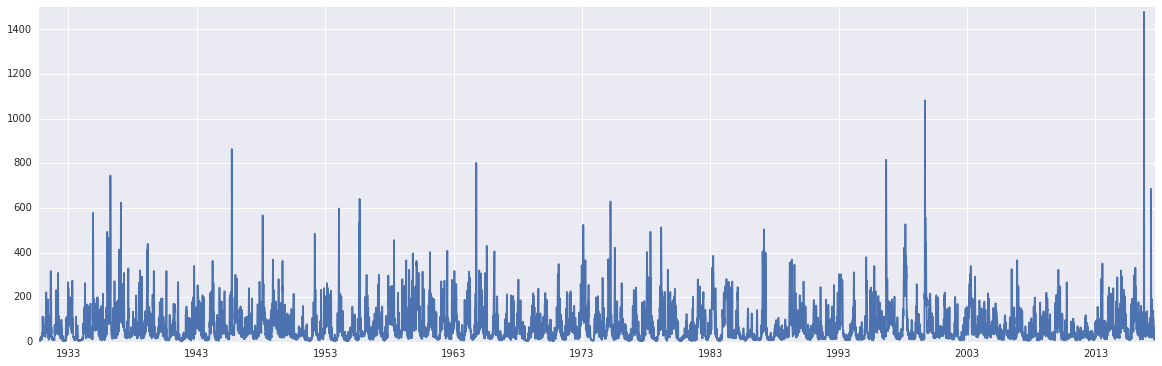

In [14]:
#Replot
plt.figure(figsize=(20,6));
plt.plot(df['datetime'],df['MeanFlow_mps']);
plt.ylim((0,1500))

### ♦ Exercise ♦ : 
Convert flow in cfs to flow in million gallons per day (MGD) and replot.

In [15]:
#Convert from csf to mgd (1 CFS = 0.53817 MGD)

In [16]:
#Replot

## Summarize our data

In [17]:
#Get a count of all records from the dataframe's shape (rows, columns)
df.shape

(31750, 6)

In [18]:
#Or just show the rows, i.e., the first item in the shape result
df.shape[0]

31750

### Summarizing/grouping records by Confidence code
Here, we group the data by the unique values in a column, namely the `Confidence` column. First, we'll just examine the number of unique values and what those values are. 

In [19]:
#Use nunique on the column to list the number of unique values
print(df['Confidence'].nunique())

4


In [20]:
#Use unique to show what the 4 unique values are
print(df['Confidence'].unique())

['A' 'A:e' 'P' 'P:e']


Now, we'll **group** the records by confidence codes

In [21]:
#Create the Pandas GroupBy object
grpConfidence = df.groupby(['Confidence'])

In [22]:
#We can now list the counts of records by confidence code
grpConfidence.count()

,agency_cd,site_no,datetime,MeanFlow_cfs,MeanFlow_mps
Confidence,,,,,
A,31371,31371,31371,31371,31371
A:e,41,41,41,41,41
P,336,336,336,336,336
P:e,2,2,2,2,2


In [23]:
#Or we can just show the count by a single column
grpConfidence['MeanFlow_cfs'].count()

Confidence
A      31371
A:e       41
P        336
P:e        2
Name: MeanFlow_cfs, dtype: int64

### Plot counts by confidence code

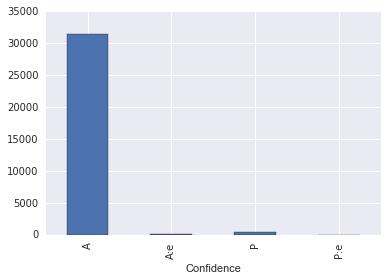

In [24]:
#https://pandas.pydata.org/pandas-docs/stable/visualization.html
count_by_Confidence = grpConfidence['MeanFlow_cfs'].count()
count_by_Confidence.plot(kind='bar');

### Generating summary statistics with `Describe`

In [25]:
#Summarize the MeanFlow_cfs data, using default outputs
df['MeanFlow_cfs'].describe()

count    31750.000000
mean      2456.054110
std       2812.195361
min         78.000000
25%        662.000000
50%       1380.000000
75%       3190.000000
max      52200.000000
Name: MeanFlow_cfs, dtype: float64

In [26]:
#Summarize, using our own percentiles
sumAll = df['MeanFlow_cfs'].describe(percentiles=[0.1,0.25,0.75,0.9])
sumAll

count    31750.000000
mean      2456.054110
std       2812.195361
min         78.000000
10%        385.000000
25%        662.000000
50%       1380.000000
75%       3190.000000
90%       6180.000000
max      52200.000000
Name: MeanFlow_cfs, dtype: float64

In [27]:
#Describe records before 1980 and after 1984 (using index slicing, as above)
sumPre = dfPre['MeanFlow_cfs'].describe(percentiles=[0.1,0.25,0.75,0.9])
sumPost = dfPost['MeanFlow_cfs'].describe(percentiles=[0.1,0.25,0.75,0.9])

In [28]:
#Concatenate (or join) the pre and post summary objects
dfSummary = pd.concat([sumAll,sumPre,sumPost],axis=1)
dfSummary.columns = ("all","before","after")

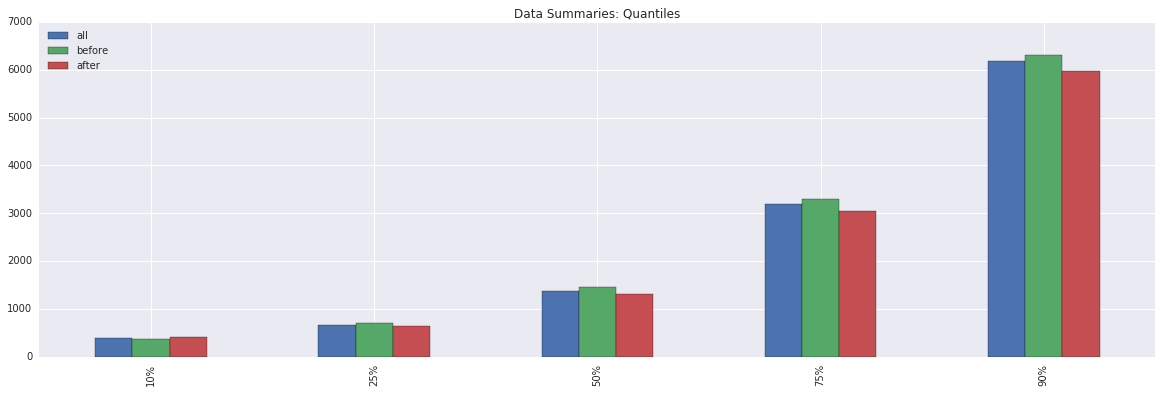

In [29]:
#Plot bar charts of the three summary tables
dfSummary[4:9].plot(kind='bar',
                    figsize=(20,6),
                    title="Data Summaries: Quantiles");

## Monthly plots
To produce monthly plots, we need to group our data by month, then plot. Grouping by month requires us to extract the month from the datetime column. 

In [30]:
#Extract the month from the datetime column
df['Mo'] = df['datetime'].map(lambda x: x.month)
df.head()

,agency_cd,site_no,datetime,MeanFlow_cfs,Confidence,MeanFlow_mps,Mo
datetime,,,,,,,
1930-10-01,USGS,02089000,1930-10-01,210.0,A,5.946538,10
1930-10-02,USGS,02089000,1930-10-02,188.0,A,5.323567,10
1930-10-03,USGS,02089000,1930-10-03,200.0,A,5.663369,10
1930-10-04,USGS,02089000,1930-10-04,200.0,A,5.663369,10
1930-10-05,USGS,02089000,1930-10-05,200.0,A,5.663369,10


In [31]:
byMonth = df.groupby('Mo')

In [32]:
monthlyDF = byMonth['MeanFlow_cfs'].mean()

In [33]:
monthlyDF

Mo
1     3524.817204
2     4206.766477
3     4439.791250
4     3433.739464
5     2045.092325
6     1511.170498
7     1636.451984
8     1688.078235
9     1753.828494
10    1515.294401
11    1539.447510
12    2275.121987
Name: MeanFlow_cfs, dtype: float64

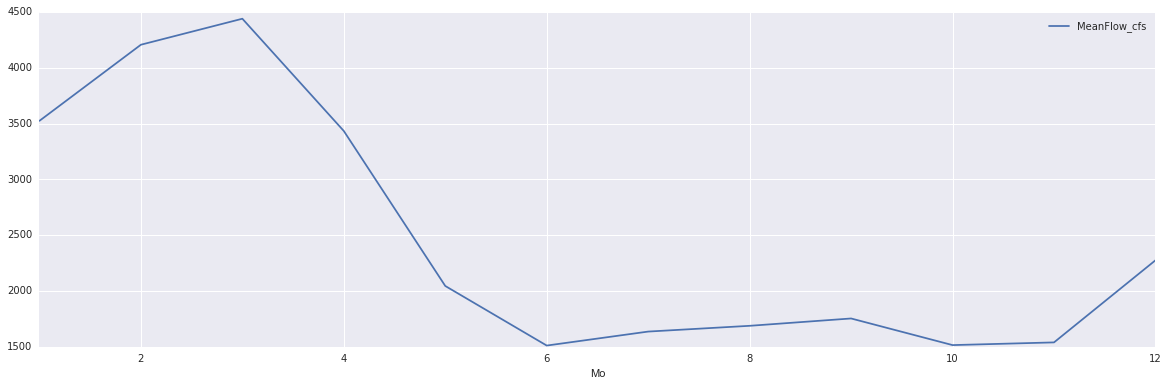

In [34]:
monthlyDF.plot(figsize=(20,6),legend=True);

## ♦Exercise♦: Annual plots
* Add a year column to your dataframe
* Group by year
* Compute the total (sum) annual discharge
* Create a plot

In [35]:
#Add a year column


In [36]:
#Group by year


In [37]:
#Compute total annual discharge


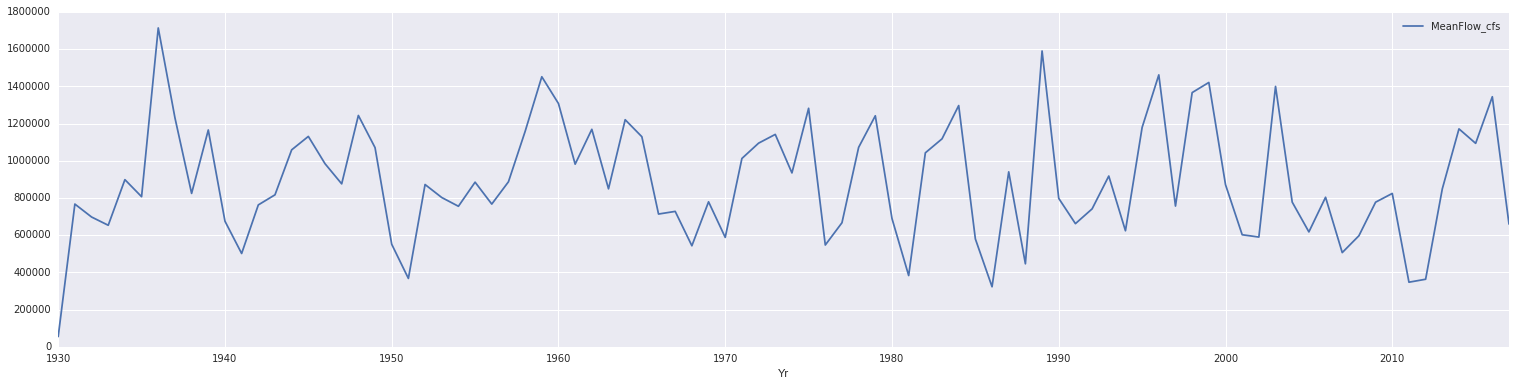

In [38]:
#Plot
